<a href="https://colab.research.google.com/github/cztm/MLOps/blob/main/mlops.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# 1. Force uninstall protobuf completely
# !pip uninstall -y protobuf

# 2. Install compatible version (<6)
!pip install "protobuf<6.0.0"  # Safe choice: 3.20.3

# 3. Install everything else AFTER fixing protobuf
!pip install google-cloud-secret-manager
!pip install transformers accelerate --quiet
!pip install google-cloud-storage==2.14.0
!pip install datasets
# !pip install bert-score
# !pip install rouge-score
!pip install mlflow
!pip install gcsfs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 217.1/217.1 kB 13.1 MB/s eta 0:00:00


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 82.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 86.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 106.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 121.6/121.6 kB 10.8 MB/s eta 0:00:00
  Attempting uninstall: google-cloud-storage
    Found existing installation: google-cloud-storage 2.19.0
    Uninstall

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 32.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 12.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 19.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 19.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 86.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 134.8 MB/s eta 0:00:00
   ━━━━

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)


Mounted at /content/drive


In [3]:
!cp /content/drive/MyDrive/'Colab Notebooks'/bundle_classes.py .

In [4]:
import os
import json
import gcsfs
import torch
import mlflow
import joblib
import shutil
import random
import tempfile
import numpy as np
import pandas as pd

from google.colab import auth
from google.colab import files
from google.oauth2 import service_account
from google.cloud import storage, secretmanager

from tqdm import tqdm
# from bert_score import score
from datasets import Dataset
# from rouge_score import rouge_scorer
from torch.utils.data import DataLoader

from mlflow.tracking import MlflowClient
from huggingface_hub import notebook_login

from sentence_transformers import models
from sklearn.neighbors import KNeighborsClassifier
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
from bundle_classes import TOSSAMKNNBundleEmbedded, PPSAMKNNBundleEmbedded
from sentence_transformers import losses, SentenceTransformer, InputExample, SentencesDataset, LoggingHandler
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve, precision_recall_fscore_support

In [5]:
notebook_login()
auth.authenticate_user()

# GCP / MLFlow Setup

## GCP Mounting

In [6]:
project_id = "fineprint-457018"
secret_id = "access_keys"
version_id = "latest"

In [7]:
client = secretmanager.SecretManagerServiceClient()

In [8]:
name = f"projects/{project_id}/secrets/{secret_id}/versions/{version_id}"

response = client.access_secret_version(request={"name": name})
secret_content = response.payload.data.decode("UTF-8")

In [9]:
os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "sa-private-key.json"

In [10]:
with open("temp_credentials.json", "w") as f:
    f.write(secret_content)

os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = "temp_credentials.json"


## MLFlow Setup


In [11]:
mlflow.set_tracking_uri("https://mlflow-server-938641055412.us-west2.run.app")  # Local tracking
mlflow.set_experiment("4.25.25")

2025/04/26 05:00:40 INFO mlflow.tracking.fluent: Experiment with name '4.25.25' does not exist. Creating a new experiment.


<Experiment: artifact_location='gs://fineprint-training/mlruns/766751549809454580', creation_time=1745643639984, experiment_id='766751549809454580', last_update_time=1745643639984, lifecycle_stage='active', name='4.25.25', tags={}>

# Summarization


In [12]:
# model_id = "mistralai/Mistral-7B-Instruct-v0.2"

# tokenizer = AutoTokenizer.from_pretrained(model_id)
# model = AutoModelForCausalLM.from_pretrained(model_id, device_map="auto", torch_dtype="auto")

# pipe = pipeline("text-generation", model=model, tokenizer=tokenizer)


In [13]:
bucket_name = "fineprint-training"
blob_name = "data/stage2-analyzing/summaries.json"

In [14]:
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(blob_name)

In [15]:
json_str = blob.download_as_text()
data = json.loads(json_str)

In [16]:
df = pd.DataFrame(data)
df.head()

,plain_text,summary
0,We can change these Terms at any time. We keep...,"Users should revisit the terms periodically, a..."
1,How To File a DMCA Notice To submit a notice o...,This service will aid you when other users inf...
2,You can see our previous Privacy Policy her...,There is a date of the last update of the agre...
3,One concrete way we commit to user privacy is ...,This service respects your browser's Do Not Tr...
4,The categories of information we collect can i...,The service provides details about what kinds ...


In [17]:
system_prompt = """
You are an AI assistant that summarizes long legal documents — including Terms of Service and Privacy Policies — into short, clear paragraphs that help users quickly understand what they are agreeing to.

Your goal is to explain the most important points in **plain language** so users can make informed decisions. Focus especially on:

- What rights the user gives up
- How their data is collected, used, stored, or shared
- What risks or responsibilities the user takes on
- What happens in the case of account issues, disputes, or termination
- Any mention of their data being sold (with or without consent)
- Any unusual or concerning terms (e.g., hidden fees, arbitration, content ownership)

Guidelines:
- Write a single **concise paragraph**, no more than **4–6 sentences**
- Do not use bullet points
- Be neutral and informative, but if something is potentially concerning, include it plainly
- Do not repeat legal language; translate it into something any teen or adult can understand

Examples:

---

**Document Type: Terms of Service**

Summary:
By using this service, you agree to give the company wide control over your account and uploaded content. They can change the rules at any time without notifying you, and using the app means you automatically accept those changes. If there’s a problem or dispute, you can't sue — you have to go through arbitration privately. The company also isn’t responsible if the service breaks or your data is lost.

---

**Document Type: Privacy Policy**

Summary:
This policy explains how your data is collected and used. The company gathers personal information, device data, and activity logs, and shares it with third-party partners, including advertisers. They may also use cookies and track your behavior across sites. There’s no option to use the service without data collection, and while they mention "anonymization," it's not clearly defined.

---

Now summarize the following document:
"""


In [18]:
def batch_and_generate(bucket_df, batch_size, desc=""):
  with mlflow.start_run():
      mlflow.log_param("model", "mistral-7b")
      mlflow.log_param("prompt", system_prompt)

      for start_idx in tqdm(range(0, len(bucket_df), batch_size), desc=desc):
        batch = bucket_df.iloc[start_idx:start_idx + batch_size]
        prompts = [
            f"{system_prompt.strip()}\n\n{row['plain_text'].strip()}\n\nSummary:" for _, row in batch.iterrows()]
        try:
            responses = pipe(prompts, max_new_tokens=100, do_sample=False)
            for row, resp in zip(batch.itertuples(index=False), responses):
                gen_text = resp[0]['generated_text'] if isinstance(resp, list) else resp['generated_text']
                generated_summary = gen_text.split("Summary:")[-1].strip()
                generated.append({
                    "original_text": row.plain_text[:100] + "...",
                    "ground_truth": row.summary[:100] + "...",
                    "generated_summary": generated_summary[:100] + "..."
                })
                torch.cuda.empty_cache()
        except Exception as e:
          print(f"❌ Error at index {start_idx}: {e}")
          torch.cuda.empty_cache()
          continue

In [19]:
# df["token_length"] = df["plain_text"].apply(lambda x: len(tokenizer.encode(x)))
# df["token_length"].describe()

In [20]:
# # Filter buckets
# short_df = df[df["token_length"] <= 1000]
# medium_df = df[(df["token_length"] > 1000) & (df["token_length"] <= 2000)]
# long_df = df[(df["token_length"] > 2000) & (df["token_length"] <= 3500)]
# xlong_df = df[df["token_length"] > 3500].sort_values("token_length")

In [21]:
# Process buckets
generated = []
# batch_and_generate(short_df, batch_size=8, desc="Short prompts")
# batch_and_generate(medium_df, batch_size=4, desc="Medium prompts")
# batch_and_generate(long_df, batch_size=2, desc="Long prompts")

In [22]:
# # Solo long rows
# for i, row in tqdm(xlong_df.iterrows(), total=len(xlong_df), desc="XL prompts"):
#     prompt = f"Summarize the following Terms of Service clearly and concisely:\n\n{row['plain_text']}\n\nSummary:"
#     try:
#         response = pipe(prompt, max_new_tokens=100, do_sample=False)
#         gen_text = response[0]['generated_text'] if isinstance(response, list) else response['generated_text']
#         generated_summary = gen_text.split("Summary:")[-1].strip()
#         generated.append({
#             "original_text": row["plain_text"][:100] + "...",
#             "ground_truth": row["summary"][:100] + "...",
#             "generated_summary": generated_summary[:100] + "..."
#         })
#         torch.cuda.empty_cache()
#     except Exception as e:
#         print(f"❌ Error on XL row {i}: {e}")
#         torch.cuda.empty_cache()
#         continue

In [23]:
# results_df = pd.DataFrame(generated)
# results_df.head()

In [24]:
# P, R, F1 = score(results_df["generated_summary"].tolist(), results_df["ground_truth"].tolist(), lang="en", verbose=True)

# results_df["bertscore_f1"] = [f.item() for f in F1]

In [25]:
# with mlflow.start_run():
#     for index, row in results_df.iterrows():
#         mlflow.log_metric("bertscore_precision", P[index].item(), step=index)
#         mlflow.log_metric("bertscore_recall", R[index].item(), step=index)
#         mlflow.log_metric("bertscore_f1", F1[index].item(), step=index)

In [26]:
# # Best summaries
# results_df.sort_values("bertscore_f1", ascending=False).head(10)

# # Worst summaries
# results_df.sort_values("bertscore_f1").head(10)


In [27]:
# results_df.to_csv('generated_summaries.csv', index=False)
# mlflow.log_artifact('generated_summaries.csv')

## Model Logging


In [28]:
# model = AutoModelForCausalLM.from_pretrained("mistral_model")
# tokenizer = AutoTokenizer.from_pretrained("mistral_model")

In [29]:
# model.save_pretrained("hf_artifacts")
# tokenizer.save_pretrained("hf_artifacts")

# with mlflow.start_run():
#     mlflow.log_artifacts("hf_artifacts", artifact_path="hf_mistral")

In [30]:
# run_id = "3781d1a630db4ba8949959753cf7e239"
# model_uri = f"runs:/{run_id}/mistral_pipe_model"

# client = MlflowClient()
# client.create_registered_model("mistral-prod")  # only if not already created

# # Register the model version
# result = client.create_model_version(
#     name="mistral-prod",
#     source=model_uri,
#     run_id=run_id
# )

# Classification

### Terms and Services

In [31]:
blob_name = "data/stage2-analyzing/tos_dataset.json"

In [32]:
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(blob_name)

In [33]:
tos_json_str = blob.download_as_text()
tos_data = json.loads(tos_json_str)

In [34]:
tos_df = pd.DataFrame(tos_data)
tos_df.head()

,clause,label
0,Company shall not specify the business practic...,Non-Disparagement
1,"MA may not assign, sell, lease or otherwise tr...",Anti-Assignment
2,INITIAL ORDER COMMITMENT - MA commits to purch...,Minimum Commitment
3,"Company hereby grants MA, during the term of t...",License Grant
4,Subject to the terms and conditions of this Ag...,License Grant


In [35]:
labels = tos_df["label"].unique()

themap = {}
i = 0
for label in labels:
  themap[label] = i
  i += 1

In [36]:
tos_df['label'] = tos_df['label'].map(themap)

In [37]:
tossam_df = tos_df.sample(frac=1)
tossam_df_remaining = tossam_df[1000:]
tossam_holdout = tossam_df[:1000]

In [38]:
tossam_train_df = tossam_df_remaining.copy()
tossam_holdout_df = tossam_holdout.copy()

In [39]:
tossam_examples = []
tos_texts = tossam_train_df['clause'].tolist()
tos_labels = tossam_train_df['label'].tolist()

In [40]:
for _ in range(2500):
    idxs = [i for i in range(len(tos_labels))]
    i = random.choice(idxs)
    j = random.choice([k for k in idxs if k != i and tos_labels[k] == tos_labels[i]])
    tossam_examples.append(InputExample(texts=[tos_texts[i], tos_texts[j]], label=1.0))

# Create 1000 negative pairs (different label)
for _ in range(2500):
    i = random.choice(idxs)
    j = random.choice([k for k in idxs if tos_labels[k] != tos_labels[i]])
    tossam_examples.append(InputExample(texts=[tos_texts[i], tos_texts[j]], label=0.0))

In [41]:
tos_word_embedding_model = models.Transformer('nlpaueb/legal-bert-base-uncased')

config.json:   0%|          | 0.00/1.02k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/222k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

In [42]:
tos_pooling_model = models.Pooling(
    tos_word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False)

In [43]:
tossam_model = SentenceTransformer(modules=[tos_word_embedding_model, tos_pooling_model])

In [44]:
tos_train_loss = losses.CosineSimilarityLoss(model=tossam_model)

In [45]:
tossam_train_dataset = SentencesDataset(tossam_examples, model=tossam_model)

In [46]:
tossam_train_loader = DataLoader(tossam_examples, shuffle=True, batch_size=16)

In [47]:
tossam_model.fit(
    train_objectives=[(tossam_train_loader, tos_train_loss)],
    epochs=10,
    warmup_steps=150
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: cztm1779 (cztm1779-fineprint) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Step,Training Loss
500,0.107800
1000,0.026400
1500,0.010700
2000,0.006000
2500,0.003500
3000,0.002600


🏃 View run checkpoints/model at: https://mlflow-server-938641055412.us-west2.run.app/#/experiments/766751549809454580/runs/f171ba3eb7ba41149e45f823ddc5f312
🧪 View experiment at: https://mlflow-server-938641055412.us-west2.run.app/#/experiments/766751549809454580


In [48]:
tossam_holdout_df['clause'] = tossam_holdout_df['clause'].fillna("").astype(str)
tossam_train_df['clause'] = tossam_train_df['clause'].fillna("").astype(str)

In [49]:
tos_X_train = tossam_model.encode(tossam_train_df['clause'].tolist(), normalize_embeddings=True, convert_to_numpy=True)
tos_X_holdout = tossam_model.encode(tossam_holdout_df['clause'].tolist(), normalize_embeddings=True, convert_to_numpy=True)

In [50]:
non_tos_X_train = tossam_model.encode(tossam_train_df['clause'].tolist(), convert_to_numpy=True)
non_tos_X_holdout = tossam_model.encode(tossam_holdout_df['clause'].tolist(), convert_to_numpy=True)

In [51]:
np.save("training_embeddings.npy", tos_X_train)
np.save("holdout_embeddings.npy", tos_X_holdout)

# mlflow.log_artifact("training_embeddings.npy")
# mlflow.log_artifact("holdout_embeddings.npy")

In [52]:
tos_y_train = tossam_train_df['label'].values
tos_y_holdout = tossam_holdout_df['label'].values

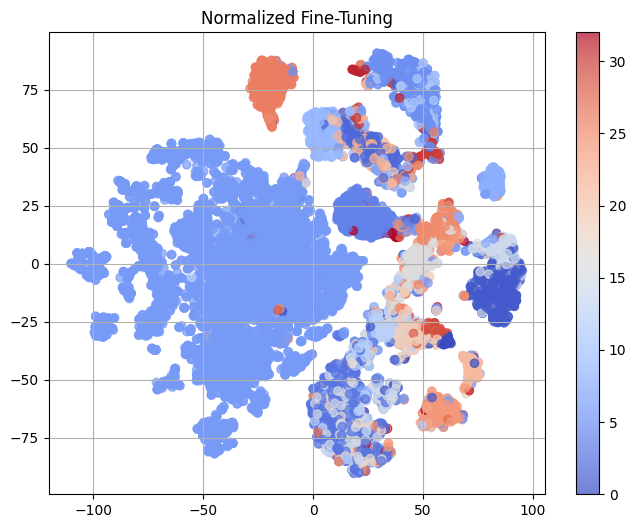

In [53]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, perplexity=30)
    reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8,6))
    plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.title(title)
    plt.colorbar()
    plt.grid(True)
    plt.show()

plot_tsne(tos_X_train, tos_y_train, "Normalized Fine-Tuning")

In [54]:
tos_knn = KNeighborsClassifier(n_neighbors=3, metric='cosine')
tos_knn.fit(tos_X_train, tos_y_train)
tos_y_pred = tos_knn.predict(tos_X_holdout)

In [55]:
report = classification_report(tos_y_holdout, tos_y_pred, output_dict=True)

# Log core metrics (adjust as needed)
mlflow.log_metric("precision", report["1"]["precision"])
mlflow.log_metric("recall", report["1"]["recall"])
mlflow.log_metric("f1", report["1"]["f1-score"])
mlflow.log_metric("accuracy", report["accuracy"])

print(classification_report(tos_y_holdout, tos_y_pred))

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


              precision    recall  f1-score   support

           0       0.50      0.50      0.50         2
           1       0.79      0.85      0.81        39
           2       0.67      0.78      0.72        18
           3       0.41      0.66      0.50        41
           4       0.94      1.00      0.97        50
           5       0.81      0.83      0.82        47
           6       0.99      0.98      0.99       505
           7       1.00      0.50      0.67         2
           8       0.90      0.90      0.90        20
           9       0.79      0.79      0.79        19
          10       0.00      0.00      0.00         4
          11       0.25      0.18      0.21        11
          12       0.33      0.21      0.26        29
          13       1.00      0.25      0.40         4
          14       0.58      0.50      0.54        14
          15       0.20      0.12      0.15        16
          16       0.83      0.68      0.75        22
          17       0.00    

/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [56]:
mlflow.end_run()

🏃 View run bittersweet-mule-491 at: https://mlflow-server-938641055412.us-west2.run.app/#/experiments/766751549809454580/runs/876e8ee3c8f94c48a26d0c68594a1bc2
🧪 View experiment at: https://mlflow-server-938641055412.us-west2.run.app/#/experiments/766751549809454580


In [57]:
# mlflow.set_experiment("TOS-classifier")

# with mlflow.start_run() as run:
#     mlflow.sklearn.log_model(
#         sk_model=knn,
#         artifact_path="tos_knn_model",
#         registered_model_name="ToSKNNClassifier")

#     print("Run ID:", run.info.run_id)

### Privacy Policy

In [58]:
blob_name = "data/stage2-analyzing/pp_dataset.json"

In [59]:
client = storage.Client()
bucket = client.bucket(bucket_name)
blob = bucket.blob(blob_name)

In [60]:
pp_json_str = blob.download_as_text()
pp_data = json.loads(pp_json_str)

In [61]:
pp_df = pd.DataFrame(pp_data)
pp_df.head()

,clause,label
0,Operation and support information. Baidu AI Cl...,GenData
1,"To improve services, Baidu AI Cloud records yo...",GenData
2,8. Please note: In the following circumstances...,GenData
3,We use the collected information to provide an...,GenUse
4,We will use the data for research for public i...,GenUse


In [62]:
clause_map = {'GenData': 0, 'GenUse': 1, 'NoDist': 2}
pp_df['label'] = pp_df['label'].map(clause_map)

In [63]:
ppsam_df = pp_df.sample(frac=1)
ppsam_df_remaining = ppsam_df[:1000]
ppsam_holdout = ppsam_df[1000:]

In [64]:
ppsam_train_df = ppsam_df_remaining.copy()
ppsam_holdout_df = ppsam_holdout.copy()

In [65]:
ppsam_examples = []
texts = ppsam_train_df['clause'].tolist()
labels = ppsam_train_df['label'].tolist()

In [66]:
for _ in range(1500):
    idxs = [i for i in range(len(labels))]
    i = random.choice(idxs)
    j = random.choice([k for k in idxs if k != i and labels[k] == labels[i]])
    ppsam_examples.append(InputExample(texts=[texts[i], texts[j]], label=1.0))

# Create 1000 negative pairs (different label)
for _ in range(1500):
    i = random.choice(idxs)
    j = random.choice([k for k in idxs if labels[k] != labels[i]])
    ppsam_examples.append(InputExample(texts=[texts[i], texts[j]], label=0.0))

In [67]:
word_embedding_model = models.Transformer('nlpaueb/legal-bert-base-uncased')

In [68]:
pooling_model = models.Pooling(
    word_embedding_model.get_word_embedding_dimension(),
    pooling_mode_mean_tokens=True,
    pooling_mode_cls_token=False,
    pooling_mode_max_tokens=False)

In [69]:
ppsam_model = SentenceTransformer(modules=[word_embedding_model, pooling_model])

In [70]:
train_loss = losses.CosineSimilarityLoss(model=ppsam_model)

In [71]:
ppsam_train_dataset = SentencesDataset(ppsam_examples, model=ppsam_model)

In [72]:
ppsam_train_loader = DataLoader(ppsam_examples, shuffle=True, batch_size=16)

In [73]:
ppsam_model.fit(
    train_objectives=[(ppsam_train_loader, train_loss)],
    epochs=25,
    warmup_steps=150
)

Computing widget examples:   0%|          | 0/1 [00:00<?, ?example/s]

Step,Training Loss
500,0.133200
1000,0.046500
1500,0.031700
2000,0.025400
2500,0.021000


🏃 View run checkpoints/model_1 at: https://mlflow-server-938641055412.us-west2.run.app/#/experiments/766751549809454580/runs/f4c9b42895aa4711b3169bba19ed5e83
🧪 View experiment at: https://mlflow-server-938641055412.us-west2.run.app/#/experiments/766751549809454580


In [74]:
ppsam_holdout_df['clause'] = ppsam_holdout_df['clause'].fillna("").astype(str)
ppsam_train_df['clause'] = ppsam_train_df['clause'].fillna("").astype(str)

In [75]:
X_train = ppsam_model.encode(ppsam_train_df['clause'].tolist(), normalize_embeddings=True, convert_to_numpy=True)
X_holdout = ppsam_model.encode(ppsam_holdout_df['clause'].tolist(), normalize_embeddings=True, convert_to_numpy=True)

In [76]:
np.save("training_embeddings.npy", X_train)
np.save("holdout_embeddings.npy", X_holdout)

# mlflow.log_artifact("training_embeddings.npy")
# mlflow.log_artifact("holdout_embeddings.npy")

In [77]:
y_train = ppsam_train_df['label'].values
y_holdout = ppsam_holdout_df['label'].values

In [78]:
mlflow.end_run()

In [79]:
with mlflow.start_run():
    mlflow.log_param("model", "kNN")
    pp_knn = KNeighborsClassifier(n_neighbors=2, metric='cosine')
    pp_knn.fit(X_train, y_train)

    y_custom = pp_knn.predict(X_holdout)
    report = classification_report(y_holdout, y_custom, output_dict=True)

    # Log core metrics (adjust as needed)
    mlflow.log_metric("precision", report["1"]["precision"])
    mlflow.log_metric("recall", report["1"]["recall"])
    mlflow.log_metric("f1", report["1"]["f1-score"])
    mlflow.log_metric("accuracy", report["accuracy"])

    print(classification_report(y_holdout, y_custom))

              precision    recall  f1-score   support

           0       0.92      0.93      0.92        70
           1       0.77      0.79      0.78        98
           2       0.62      0.58      0.60        53

    accuracy                           0.78       221
   macro avg       0.77      0.77      0.77       221
weighted avg       0.78      0.78      0.78       221

🏃 View run hilarious-moose-404 at: https://mlflow-server-938641055412.us-west2.run.app/#/experiments/766751549809454580/runs/cf55490000f148e39696e522e313ece5
🧪 View experiment at: https://mlflow-server-938641055412.us-west2.run.app/#/experiments/766751549809454580


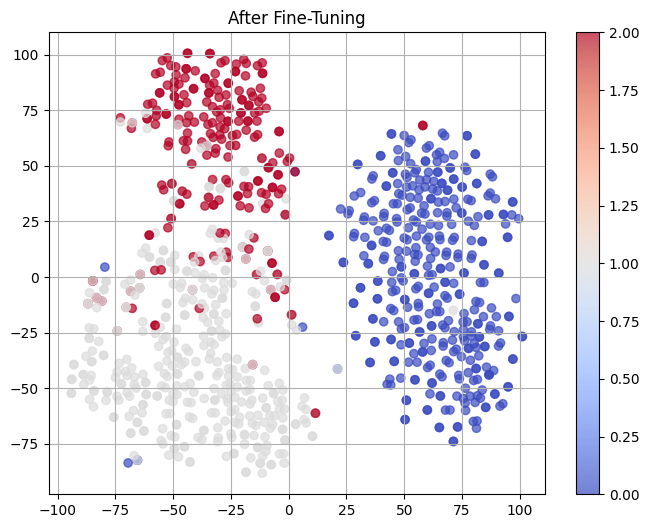

In [80]:
def plot_tsne(embeddings, labels, title):
    tsne = TSNE(n_components=2, perplexity=30)
    reduced = tsne.fit_transform(embeddings)
    plt.figure(figsize=(8,6))
    plt.scatter(reduced[:,0], reduced[:,1], c=labels, cmap='coolwarm', alpha=0.7)
    plt.title(title)
    plt.colorbar()
    plt.grid(True)
    plt.show()

plot_tsne(X_train, y_train, "After Fine-Tuning")

In [81]:
# mlflow.set_experiment("PP-classifier")

# with mlflow.start_run() as run:
#     mlflow.sklearn.log_model(
#         sk_model=knn,
#         artifact_path="pp_knn_model",
#         registered_model_name="PP_KNN_Classifier")

#     print("Run ID:", run.info.run_id)

## Logging Classification Models

In [82]:
# class PPSAMKNNBundleEmbedded:
#     def __init__(self, encoder_model, knn_model):
#        with tempfile.TemporaryDirectory() as tmpdirname:
#             encoder_model.save(tmpdirname)
#             shutil.make_archive('model_archive', 'zip', tmpdirname)
#             with open('model_archive.zip', 'rb') as f:
#                 self.encoder_bytes = f.read()
#        self.knn_model = knn_model
#        self._encoder = None

#     def _load_encoder(self):
#         with tempfile.TemporaryDirectory() as tmpdirname:
#             archive_path = os.path.join(tmpdirname, 'model_archive.zip')
#             with open(archive_path, 'wb') as f:
#                 f.write(self.encoder_bytes)
#             shutil.unpack_archive(archive_path, tmpdirname)
#             model = SentenceTransformer(tmpdirname)
#         return model

#     def predict(self, texts):
#         # Lazy load on first predict
#         if self._encoder is None:
#             self._encoder = self._load_encoder()

#         embeddings = self._encoder.encode(texts, normalize_embeddings=True, convert_to_numpy=True)
#         return self.knn_model.predict(embeddings)

In [83]:
# class TOSSAMKNNBundleEmbedded:
#     def __init__(self, encoder_model, knn_model):
#        with tempfile.TemporaryDirectory() as tmpdirname:
#             encoder_model.save(tmpdirname)
#             shutil.make_archive('model_archive', 'zip', tmpdirname)
#             with open('model_archive.zip', 'rb') as f:
#                 self.encoder_bytes = f.read()
#        self.knn_model = knn_model
#        self._encoder = None

#     def _load_encoder(self):
#         with tempfile.TemporaryDirectory() as tmpdirname:
#             archive_path = os.path.join(tmpdirname, 'model_archive.zip')
#             with open(archive_path, 'wb') as f:
#                 f.write(self.encoder_bytes)
#             shutil.unpack_archive(archive_path, tmpdirname)
#             model = SentenceTransformer(tmpdirname)
#         return model

#     def predict(self, texts):
#         # Lazy load on first predict
#         if self._encoder is None:
#             self._encoder = self._load_encoder()

#         embeddings = self._encoder.encode(texts, normalize_embeddings=True, convert_to_numpy=True)
#         return self.knn_model.predict(embeddings)

In [84]:
# tos_model = TOSSAMKNNBundleEmbedded(tossam_model, tos_knn)
# joblib.dump(tos_model, "tos_knn_bundle.joblib")

['tos_knn_bundle.joblib']

In [85]:
# pp_model = PPSAMKNNBundleEmbedded(ppsam_model, pp_knn)
# joblib.dump(pp_model, "pp_knn_bundle.joblib")

['pp_knn_bundle.joblib']

In [86]:
# client = storage.Client()
# bucket = client.bucket(bucket_name)
# blob = bucket.blob('deployable_models/pp_knn_bundle.joblib')
# blob.upload_from_filename('pp_knn_bundle.joblib')

In [87]:
# client = storage.Client()
# bucket = client.bucket(bucket_name)
# blob = bucket.blob('deployable_models/tos_knn_bundle.joblib')
# blob.upload_from_filename('tos_knn_bundle.joblib')